# **Credit Card Default Prediction using Machine Learning Techniques**

* Kevin Harmer
* Chaithra K C

# 1. Code Requirements

In [ ]:
# downloading the data and installing external libraries

%%bash
# installing pyspark, handyspark (for visualization of ROC and PR curves)
pip install pyspark &> /dev/null
pip install handyspark &> /dev/null

# downloading the data file from github and saving it this colab environment instance
data_file=UCI_Credit_Card.csv

if [[ ! -f ./${data_file} ]]; then 
   wget https://raw.githubusercontent.com/chaithrakc/CREDIT_CARD_DEFAULT_PREDICTION/main/data_files/${data_file} &> /dev/null
fi

In [ ]:
# loading required libraries

# non-spark libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics

#spark libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline, feature, classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# handyspark
from handyspark import BinaryClassificationMetrics
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [ ]:
# creating spark session and spark context
spark = SparkSession.builder.appName('credit-card-default-prediction').getOrCreate()
sc = spark.sparkContext

spark # checking the spark version

# 2. Data Essentials

### 2a. Importing the Data
**Data Source:** Dataset can be found on both of the websites listed below.


*  UC Irvine Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients 


*   Kaggle: 
https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset




In [ ]:
# reading the credit card data into spark dataframe
credit_card_df = spark.read.csv('UCI_Credit_Card.csv', header=True, inferSchema=True)

# dimensions of the dataframe
num_rows = credit_card_df.count()
num_cols = len(credit_card_df.columns)

print(f'Number of rows: {num_rows}') 
print(f'Number of columns: {num_cols}') 

Number of rows: 30000
Number of columns: 25


There are 30,000 credit card holders in the dataset. 

In [ ]:
credit_card_df.printSchema() # verifying the schema

root
 |-- ID: integer (nullable = true)
 |-- LIMIT_BAL: double (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- EDUCATION: integer (nullable = true)
 |-- MARRIAGE: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PAY_0: integer (nullable = true)
 |-- PAY_2: integer (nullable = true)
 |-- PAY_3: integer (nullable = true)
 |-- PAY_4: integer (nullable = true)
 |-- PAY_5: integer (nullable = true)
 |-- PAY_6: integer (nullable = true)
 |-- BILL_AMT1: double (nullable = true)
 |-- BILL_AMT2: double (nullable = true)
 |-- BILL_AMT3: double (nullable = true)
 |-- BILL_AMT4: double (nullable = true)
 |-- BILL_AMT5: double (nullable = true)
 |-- BILL_AMT6: double (nullable = true)
 |-- PAY_AMT1: double (nullable = true)
 |-- PAY_AMT2: double (nullable = true)
 |-- PAY_AMT3: double (nullable = true)
 |-- PAY_AMT4: double (nullable = true)
 |-- PAY_AMT5: double (nullable = true)
 |-- PAY_AMT6: double (nullable = true)
 |-- default.payment.next.month: integer (nullable

### Column Description
- ID:  ID of each credit card user
- LIMIT_BAL: credit limit
- SEX: Gender of individual (1 = male, 2 = female)
- EDUCATION: Highest level of education (1 = Graduate School, 2 = College, 3 = High School, 4 = Other)
- MARRIAGE: Martial Status (1 = married, 2 = single, 3 = other)
- AGE: age of individual (in years)
- PAY_0-PAY_6: Historical Past Payments. PAY_0 1 month previously, PAY_2 is 2 months ago, and so forth (there is no PAY_1 variable). Data measured in these columns are -1 = pay correctly, 1 = payment delay for 1 month, 2 = payment delay for 2 months, and a consistent pattern for higher values.
- BILL_AMT1-BILL_AMT6: Billing statements over the past 6 months
- PAY_AMT1-PAY_AMT6: Payment Amounts over the past 6 months
-default payment nex month: boolean representation of whether the person defaulted in the following month.

In [ ]:
# viewing sample data
credit_card_df.show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default.payment.next.month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|  20000.0|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|   3913.0|   3102.0|    689.0|      0.0|      0.0|      0.0|     0.0|   689.0|     0.0|     0.0|     0.0|     0.0|                         1|
|  2| 120000.0|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|   2682.0|   1725.0|   2682.0|   3272.0|  

**Detailed explanation of payment Status:**
* -2: No consumption. Balance paid in full and no transactions this period (we may refer to this credit card account as having been "inactive" this period)

* -1: Paid in full. Balance paid in full, but account has a positive balance at end of period due to recent transactions for which payment has not yet come due

*  0: The use of revolving credit. Customer paid the minimum due amount, but not the entire balance. I.e., the customer paid enough for their account to remain in good standing, but did revolve a balance

*  1 = payment delay for one month
*  2 = payment delay for two months

### 2b. Data Wrangling

In [ ]:
# checking NA's and duplicates
duplicates_count = credit_card_df.count() - credit_card_df.distinct().count()
print(f"There are {duplicates_count} duplicates in the data set.\n")

There are 0 duplicates in the data set.



In [ ]:
# removing the ID column
credit_card_df = credit_card_df.drop('ID')

In [ ]:
# renaming the columns to make them more meaningful
credit_card_df = credit_card_df.withColumnRenamed('PAY_0', 'PAY_STATUS_SEP').withColumnRenamed('PAY_2', 'PAY_STATUS_AUG')\
                                .withColumnRenamed('PAY_3', 'PAY_STATUS_JUL').withColumnRenamed('PAY_4', 'PAY_STATUS_JUN')\
                                .withColumnRenamed('PAY_5', 'PAY_STATUS_MAY').withColumnRenamed('PAY_6', 'PAY_STATUS_APR')\
                                .withColumnRenamed('BILL_AMT1', 'BILL_AMT_SEP').withColumnRenamed('BILL_AMT2', 'BILL_AMT_AUG')\
                                .withColumnRenamed('BILL_AMT3', 'BILL_AMT_JUL').withColumnRenamed('BILL_AMT4', 'BILL_AMT_JUN')\
                                .withColumnRenamed('BILL_AMT5', 'BILL_AMT_MAY').withColumnRenamed('BILL_AMT6', 'BILL_AMT_APR')\
                                .withColumnRenamed('PAY_AMT1', 'PAY_AMT_SEP').withColumnRenamed('PAY_AMT2', 'PAY_AMT_AUG')\
                                .withColumnRenamed('PAY_AMT3', 'PAY_AMT_JUL').withColumnRenamed('PAY_AMT4', 'PAY_AMT_JUN')\
                                .withColumnRenamed('PAY_AMT5', 'PAY_AMT_MAY').withColumnRenamed('PAY_AMT6', 'PAY_AMT_APR')\
                                .withColumnRenamed('default.payment.next.month', 'DEFAULT_NEXT_MONTH')

In [ ]:
# checking for None/Null values
missing_values = credit_card_df.select([f.count(f.when(f.col(feature).isNull(), feature)).alias(feature) for feature in credit_card_df.columns])\
                                .withColumn('Total', sum([f.col(feature) for feature in credit_card_df.columns]))
missing_values.show()

print(f"There are {missing_values.select('Total').collect()[0]['Total']} NA/Null values in the data set.\n")

+---------+---+---------+--------+---+--------------+--------------+--------------+--------------+--------------+--------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+------------------+-----+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_STATUS_SEP|PAY_STATUS_AUG|PAY_STATUS_JUL|PAY_STATUS_JUN|PAY_STATUS_MAY|PAY_STATUS_APR|BILL_AMT_SEP|BILL_AMT_AUG|BILL_AMT_JUL|BILL_AMT_JUN|BILL_AMT_MAY|BILL_AMT_APR|PAY_AMT_SEP|PAY_AMT_AUG|PAY_AMT_JUL|PAY_AMT_JUN|PAY_AMT_MAY|PAY_AMT_APR|DEFAULT_NEXT_MONTH|Total|
+---------+---+---------+--------+---+--------------+--------------+--------------+--------------+--------------+--------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+------------------+-----+
|        0|  0|        0|       0|  0|             0|             0|             0|     

**Inconsistency with the category `others`:**

As per the documentation in Kaggle, and UCI website,
* Education (1 = graduate school, 2 = university, 3 = high school, 0, 4, 5, 6 = others)
* Marital status (1 = married, 2 = single, 0, 3 = others)

Mutiple values in the `others` category will be mapped to 0 to maintain uniformity when building the model and drawing conclusions.

In [ ]:
# Education (1 = graduate school; 2 = university; 3 = high school; 0, 4, 5, 6 = others)
# Marital status (1 = married; 2 = single; 0, 3 = others)

credit_card_df = credit_card_df.replace(to_replace=[4,5,6], value=0, subset='EDUCATION')
credit_card_df = credit_card_df.replace(to_replace=3, value=0, subset='MARRIAGE')

In [ ]:
credit_card_df.show() # viewing the data after cleaning/wrangling

+---------+---+---------+--------+---+--------------+--------------+--------------+--------------+--------------+--------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_STATUS_SEP|PAY_STATUS_AUG|PAY_STATUS_JUL|PAY_STATUS_JUN|PAY_STATUS_MAY|PAY_STATUS_APR|BILL_AMT_SEP|BILL_AMT_AUG|BILL_AMT_JUL|BILL_AMT_JUN|BILL_AMT_MAY|BILL_AMT_APR|PAY_AMT_SEP|PAY_AMT_AUG|PAY_AMT_JUL|PAY_AMT_JUN|PAY_AMT_MAY|PAY_AMT_APR|DEFAULT_NEXT_MONTH|
+---------+---+---------+--------+---+--------------+--------------+--------------+--------------+--------------+--------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+------------------+
|  20000.0|  2|        2|       1| 24|             2|             2|            -1|            -1|        

In [ ]:
# converting spark dataframe to pandas dataframe for visualization
credit_card_pd = credit_card_df.toPandas()

# 3. Data Exploration

### 3a. Summary Statistics

In [ ]:
# descriptive statistics
credit_card_df.summary().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+--------------------+------------------+--------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-------------------+
|summary|         LIMIT_BAL|               SEX|         EDUCATION|          MARRIAGE|              AGE|    PAY_STATUS_SEP|      PAY_STATUS_AUG|    PAY_STATUS_JUL|      PAY_STATUS_JUN|    PAY_STATUS_MAY|   PAY_STATUS_APR|     BILL_AMT_SEP|     BILL_AMT_AUG|     BILL_AMT_JUL|      BILL_AMT_JUN|     BILL_AMT_MAY|    BILL_AMT_APR|      PAY_AMT_SEP|       PAY_AMT_AUG|      PAY_AMT_JUL|       PAY_AMT_JUN|       PAY_AMT_MAY|      PAY_AMT_APR| DEFAULT_NEXT_MONTH|
+-------+------------------+------------------+------------------+--------------

### 3b. Correlation Matrix

In [ ]:
# Correlation Matrix

# assembling the features for correlation matrix
corr_assembler = feature.VectorAssembler(inputCols=credit_card_df.columns, outputCol='corr_features')
corr_df = corr_assembler.transform(credit_card_df).select('corr_features')

# genereating pearson correlation matrix
pearson_corr = Correlation.corr(corr_df, 'corr_features').collect()[0][0]

# converting spark correlation matrix into pandas dataframe for visulizing using heat map
corr_matrix_pd = pd.DataFrame(data=pearson_corr.toArray(), columns=credit_card_df.columns, index=credit_card_df.columns)
corr_matrix_pd = np.round(corr_matrix_pd,2)

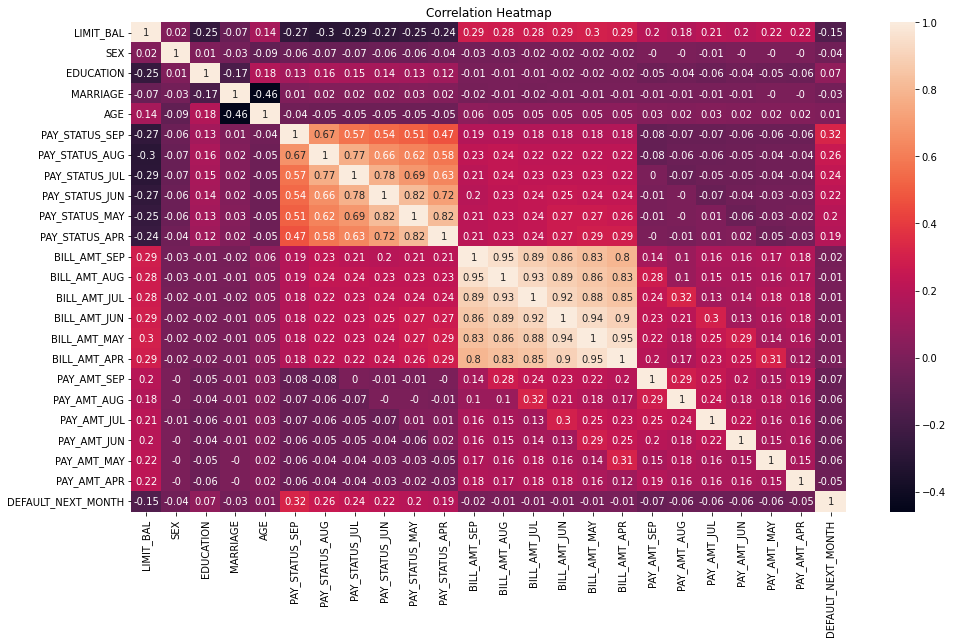

In [ ]:
# plotting correlation matrix of entire data set

plt.figure(figsize=(16,9))
plt.title('Correlation Heatmap')
sns.heatmap(corr_matrix_pd, annot=True)
plt.show()

**Filtering Strong Correlations:**

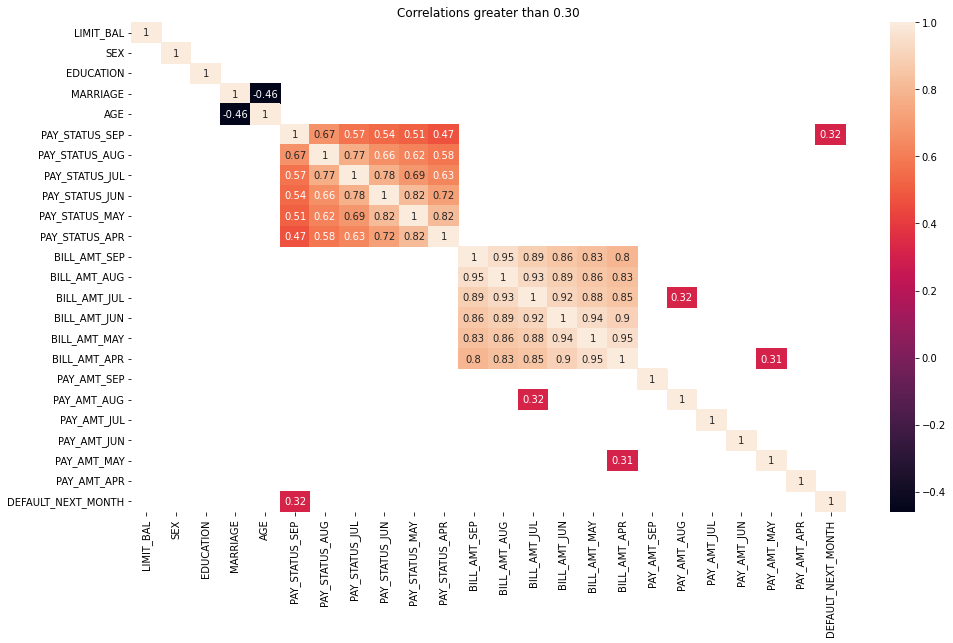

In [ ]:
# plotting only the strong correlations

# rule of thumb (applies to both postive and negative correlation): 
  # Weak correlation (corr < 0.30) - can be ignored
	# Worth exploring (corr > 0.30)
corr_grt_30 = corr_matrix_pd[(corr_matrix_pd > 0.30) | (corr_matrix_pd < -0.30)]

plt.figure(figsize=(16,9))
plt.title('Correlations greater than 0.30')
sns.heatmap(corr_grt_30, annot=True)
plt.show()

**Specific Payment Correlations:**

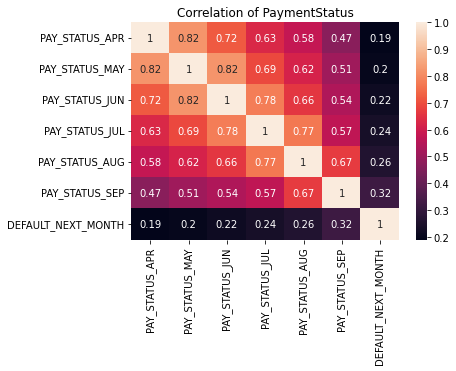

In [ ]:
payment_index_col = ['PAY_STATUS_APR', 'PAY_STATUS_MAY', 'PAY_STATUS_JUN',
                     'PAY_STATUS_JUL', 'PAY_STATUS_AUG', 'PAY_STATUS_SEP', 'DEFAULT_NEXT_MONTH']

plt.title('Correlation of PaymentStatus')
sns.heatmap(corr_matrix_pd.loc[payment_index_col,payment_index_col], annot=True)
plt.show()

### 3c. Exploring the number of missed payments

In [ ]:
# extracting the number of missed payments
credit_card_pd['DEFAULT_NEXT_MONTH_LABEL'] = credit_card_pd['DEFAULT_NEXT_MONTH'].replace({0:'NON_DELINQUENT', 1:'DELINQUENT'})

payments_pd = credit_card_pd.loc[:,['PAY_STATUS_APR',	'PAY_STATUS_MAY',	'PAY_STATUS_JUN',	'PAY_STATUS_JUL',	'PAY_STATUS_AUG',	
                             'PAY_STATUS_SEP', 'DEFAULT_NEXT_MONTH_LABEL']].copy()
payments_pd['MISSED_PAYMENTS'] = payments_pd.max(axis=1)

In [ ]:
default_freq_df = payments_pd.groupby(['MISSED_PAYMENTS','DEFAULT_NEXT_MONTH_LABEL']).agg(COUNT=('MISSED_PAYMENTS',len)).reset_index()
default_freq_df = default_freq_df[default_freq_df['MISSED_PAYMENTS'] >0]

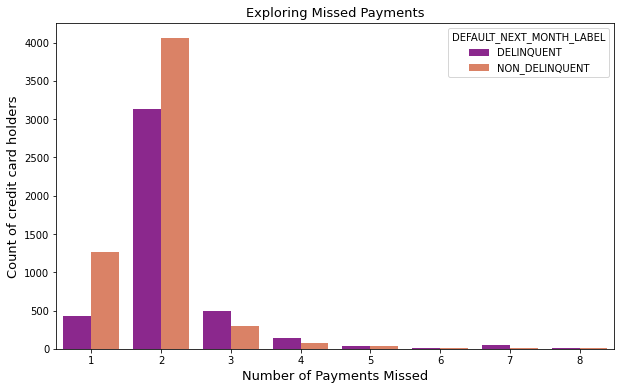

In [ ]:
# bar plot
plt.figure(figsize=(10,6))
plt.title('Exploring Missed Payments', fontsize=13)
sns.barplot(data=default_freq_df, x='MISSED_PAYMENTS', y='COUNT', hue='DEFAULT_NEXT_MONTH_LABEL', palette='plasma')
plt.xlabel('Number of Payments Missed', fontsize=13)
plt.ylabel('Count of credit card holders', fontsize=13)
plt.show()

### 3d. Examining delinquency of credit card payments across different age groups:


In [ ]:
# creating bins for each age groups
age_bins = list(range(20,90,10))
age_group_labels = ['21-30','31-40','41-50','51-60','61-70','71-80']
credit_card_pd['AGE_GROUPS'] = pd.cut(x=credit_card_pd.AGE, bins=age_bins,labels=age_group_labels)

In [ ]:
credit_card_pd['DEFAULT_NEXT_MONTH_LABEL'] = credit_card_pd['DEFAULT_NEXT_MONTH'].replace({0:'NON_DELINQUENT', 1:'DELINQUENT'})
total_age_df = credit_card_pd.groupby(['AGE_GROUPS']).agg(COUNT=('AGE',len)).reset_index()
default_age_df = credit_card_pd.groupby(['AGE_GROUPS','DEFAULT_NEXT_MONTH_LABEL']).agg(COUNT=('AGE',len)).reset_index()
percent_df = pd.merge(default_age_df, total_age_df, on='AGE_GROUPS')
percent_df['%'] = np.round(percent_df['COUNT_x']/percent_df['COUNT_y'],2)

percent_df

,AGE_GROUPS,DEFAULT_NEXT_MONTH_LABEL,COUNT_x,COUNT_y,%
0,21-30,DELINQUENT,2471,11013,0.22
1,21-30,NON_DELINQUENT,8542,11013,0.78
2,31-40,DELINQUENT,2189,10713,0.20
3,31-40,NON_DELINQUENT,8524,10713,0.80
4,41-50,DELINQUENT,1399,6005,0.23
5,41-50,NON_DELINQUENT,4606,6005,0.77
6,51-60,DELINQUENT,504,1997,0.25
7,51-60,NON_DELINQUENT,1493,1997,0.75
8,61-70,DELINQUENT,68,257,0.26
9,61-70,NON_DELINQUENT,189,257,0.74


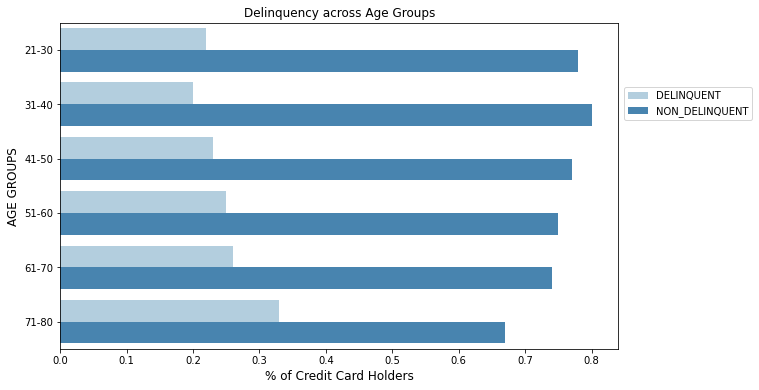

In [ ]:
# bar plot
plt.figure(figsize=(10,6))
plt.title('Delinquency across Age Groups',fontsize=12)
sns.barplot(data=percent_df, x='%', y='AGE_GROUPS', hue='DEFAULT_NEXT_MONTH_LABEL', palette='Blues')
plt.legend(loc=(1.01,0.7))
plt.xlabel('% of Credit Card Holders', fontsize=12)
plt.ylabel('AGE GROUPS',fontsize=12)
plt.show()

### 3e. Statement Balance Distribution

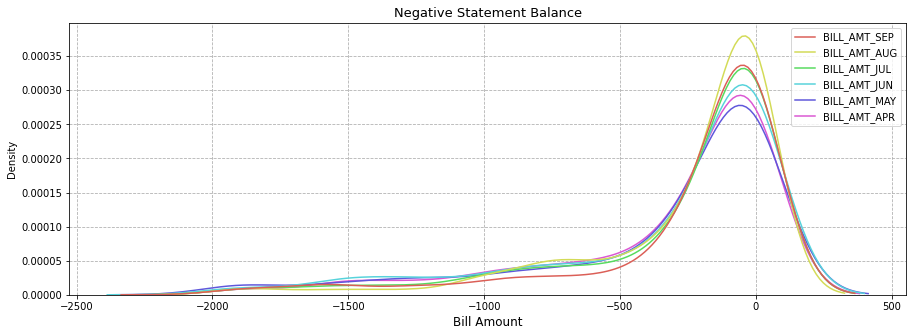

In [ ]:
bill_amnt_df = credit_card_pd[[ 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'BILL_AMT_JUN','BILL_AMT_MAY', 'BILL_AMT_APR']]
fig, ax = plt.subplots(figsize=(15,5))
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Negative Statement Balance', fontsize=13)
sns.kdeplot(data=bill_amnt_df[(bill_amnt_df<0) & (bill_amnt_df>-2000)], palette='hls',ax=ax)
plt.grid(linestyle='--', which='both')
plt.xlabel('Bill Amount', fontsize=12 )
plt.show()

### 3f. Examining credit limit to see if there is any gender prejudice

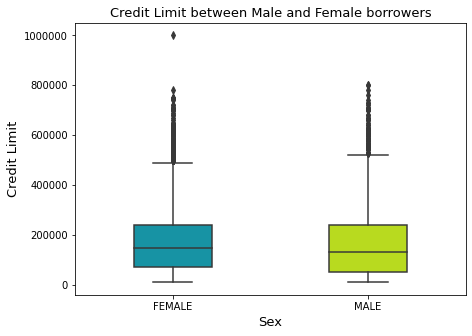

In [ ]:
# labelling the gender column for visualization
credit_card_pd['SEX_LABELLED'] = credit_card_pd['SEX'].replace({1:'MALE', 2:'FEMALE'})

plt.figure(figsize=(7,5))
plt.ticklabel_format(useOffset=False, style='plain') # suppressing scientific notation in pyplot
plt.title('Credit Limit between Male and Female borrowers',fontdict={'size': 13})
sns.boxplot(data=credit_card_pd, x='SEX_LABELLED', y='LIMIT_BAL', palette='nipy_spectral', width=0.4)
           
plt.ylabel('Credit Limit', fontdict={'size': 13})
plt.xlabel('Sex', fontdict={'size': 13})
plt.show()

**Inference**: Interquartile regions of both the boxplots highly overlap. This indicates there is no significant difference between credit limits offered to men and women.

# 4. Data Preparation and Feature Engineering for Modeling
### 4a. Resolving Class Imbalance

In [ ]:
# re-arranging the payments in the ascending order of months 
# for better understanding of month wise credit statement - statement balance, payment amount, payment status

credit_card_df = credit_card_df.select('LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                      'PAY_AMT_APR', 'PAY_STATUS_APR', 
                      'BILL_AMT_APR', 'PAY_AMT_MAY','PAY_STATUS_MAY', 
                      'BILL_AMT_MAY', 'PAY_AMT_JUN', 'PAY_STATUS_JUN',
                      'BILL_AMT_JUN','PAY_AMT_JUL','PAY_STATUS_JUL',
                      'BILL_AMT_JUL','PAY_AMT_AUG', 'PAY_STATUS_AUG',
                      'BILL_AMT_AUG', 'PAY_AMT_SEP', 'PAY_STATUS_SEP',
                      'BILL_AMT_SEP', 'DEFAULT_NEXT_MONTH')

credit_card_df.show(5)

+---------+---+---------+--------+---+-----------+--------------+------------+-----------+--------------+------------+-----------+--------------+------------+-----------+--------------+------------+-----------+--------------+------------+-----------+--------------+------------+------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_AMT_APR|PAY_STATUS_APR|BILL_AMT_APR|PAY_AMT_MAY|PAY_STATUS_MAY|BILL_AMT_MAY|PAY_AMT_JUN|PAY_STATUS_JUN|BILL_AMT_JUN|PAY_AMT_JUL|PAY_STATUS_JUL|BILL_AMT_JUL|PAY_AMT_AUG|PAY_STATUS_AUG|BILL_AMT_AUG|PAY_AMT_SEP|PAY_STATUS_SEP|BILL_AMT_SEP|DEFAULT_NEXT_MONTH|
+---------+---+---------+--------+---+-----------+--------------+------------+-----------+--------------+------------+-----------+--------------+------------+-----------+--------------+------------+-----------+--------------+------------+-----------+--------------+------------+------------------+
|  20000.0|  2|        2|       1| 24|        0.0|            -2|         0.0|        0.0|            -2| 

As seen in the below stats and the histogram, number of defaulters is around 6,636 (22%) when compared to non-defaulters around 23,364 (78%). Imbalance data can hamper the model accuracy big time.

In [ ]:
# function similar to value_count in pandas
def spark_value_count(df, column_name:str):
  return df.select(column_name)\
            .groupby(column_name)\
            .agg(f.count(column_name).alias('COUNT'),(f.round(f.count(column_name)*100/df.count(),4)).alias('PERCENTAGE'))\
            .sort('COUNT', ascending=False)

In [ ]:
# class imbalance stats
spark_value_count(credit_card_df, 'DEFAULT_NEXT_MONTH').show()

+------------------+-----+----------+
|DEFAULT_NEXT_MONTH|COUNT|PERCENTAGE|
+------------------+-----+----------+
|                 0|23364|     77.88|
|                 1| 6636|     22.12|
+------------------+-----+----------+



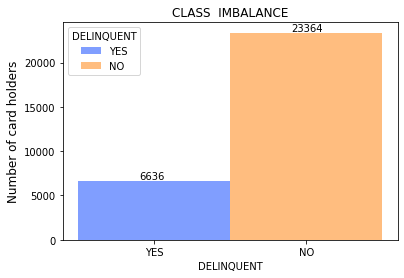

In [ ]:
# visualizing class imbalance

credit_card_pd['DELINQUENT'] = credit_card_pd['DEFAULT_NEXT_MONTH'].map({1:'YES', 0:'NO'})

plt.title('CLASS  IMBALANCE', fontsize=12)
ax = sns.histplot(data=credit_card_pd, x='DELINQUENT', edgecolor='none', hue='DELINQUENT', palette='bright')

# annotating the bar heights
for p in ax.patches:
  if p.get_height()!=0:
    ax.annotate(str(p.get_height()), (p.get_x()+0.4, p.get_height()+200))

plt.ylabel('Number of card holders', fontsize=12)
plt.show()

**Handling Class Imbalnce with "Random Under-Sampling"**:

In undersampling, random observations in the majority class are removed.This is done until the majority and minority class is balanced out.

**Drawback:** Undersampling may result in the loss of potentially valuable information.

In [ ]:
non_default_df = credit_card_df.filter(f.col('DEFAULT_NEXT_MONTH') == 0) # majority class
default_df = credit_card_df.filter(f.col('DEFAULT_NEXT_MONTH')!= 0) # minority class

# fraction of rows that needs to be undersampled from majority class (non_default)
ratio_non_default = default_df.count()/non_default_df.count() 

# random sampling the majoirty class
majority_sampled = non_default_df.sample(withReplacement=False,fraction=ratio_non_default, seed=11292022)

# combining majority class with minority class data
undersampled_df  = majority_sampled.union(default_df)

In [ ]:
print('Dataset after random undersampling:')
spark_value_count(undersampled_df, 'DEFAULT_NEXT_MONTH').show()

Dataset after random undersampling:
+------------------+-----+----------+
|DEFAULT_NEXT_MONTH|COUNT|PERCENTAGE|
+------------------+-----+----------+
|                 0| 6716|   50.2996|
|                 1| 6636|   49.7004|
+------------------+-----+----------+



### 4b. Transformations Applied to Categorical Data

* **Education** is an ordinal categorical data. It is best practice to maintain the order. Therefore, encoding the categories according to increasing level of education.

```
+-----------------+-----------------------------+
|   Education     | Transformed Education Level |
+-----------------+-----------------------------+
| Others/Unknown  |                           0 |
| High School     |                           1 |
| College         |                           2 |
| Graduate School |                           3 |
+-----------------+-----------------------------+
```

* **Marital Status** is an unordered, plain categorical variable. This column can be one hot encoded.

* **Sex**: There are only two categories in this column. We can simply encode 0/1.

```
+--------+-------------+
|  Sex   | Indexed Sex |
+--------+-------------+
| Female |           0 |
| Male   |           1 |
+--------+-------------+
```

In [ ]:
# education encoding
fe_credit_df = undersampled_df.replace(to_replace=[3,1], value=[1,3], subset='EDUCATION')

# sex and marriage encoding
oh_pipe = Pipeline(stages=[feature.StringIndexer(inputCol='SEX', outputCol='SEX_INDEXED'),
                           feature.OneHotEncoder(inputCol='MARRIAGE', outputCol='MARRIAGE_OH')]).fit(fe_credit_df)

fe_credit_df = oh_pipe.transform(fe_credit_df)

# removing the columns SEX and MARRIAGE as they are encoded in different columns
fe_credit_df = fe_credit_df.drop('SEX', 'MARRIAGE')

### 4c. Using Random Split to break into Training and Testing Data

In [ ]:
# train-test split
train, test = fe_credit_df.randomSplit(weights=[0.8, 0.2], seed=11292022)

print(f'dimensions of train: {(train.count(), len(train.columns))}') 
print(f'dimensions of test: {(test.count(), len(test.columns))}') 

dimensions of train: (10649, 24)
dimensions of test: (2703, 24)


In [ ]:
# verifying the class balance in train and test data
print('Class Balance in Training Data:')
spark_value_count(train, 'DEFAULT_NEXT_MONTH').show()

print('Class Balance in Test Data:')
spark_value_count(test, 'DEFAULT_NEXT_MONTH').show()

Class Balance in Training Data:
+------------------+-----+----------+
|DEFAULT_NEXT_MONTH|COUNT|PERCENTAGE|
+------------------+-----+----------+
|                 0| 5341|   50.1549|
|                 1| 5308|   49.8451|
+------------------+-----+----------+

Class Balance in Test Data:
+------------------+-----+----------+
|DEFAULT_NEXT_MONTH|COUNT|PERCENTAGE|
+------------------+-----+----------+
|                 0| 1375|   50.8694|
|                 1| 1328|   49.1306|
+------------------+-----+----------+



# 5. Modeling

In [ ]:
grid_search = False

enable_logistic_regression = False
enable_random_forest = False
enable_perceptron = True

### 5a. Common Methods

In [ ]:
# Binomial Regression evaluation

def binaryclf_evaluation(pred_results, labelCol:str, predictionCol:str):

  actual = pred_results.select(labelCol).collect()
  predicted = pred_results.select(predictionCol).collect()
  cnf_matrix = metrics.confusion_matrix(actual, predicted) # confusion matrix
  
  scores = {}  
  scores['AreaUnderROC'] = BinaryClassificationEvaluator(rawPredictionCol=predictionCol, labelCol=labelCol, metricName='areaUnderROC').evaluate(pred_results)
  scores['AreaUnderPR'] = BinaryClassificationEvaluator(rawPredictionCol=predictionCol, labelCol=labelCol, metricName='areaUnderPR').evaluate(pred_results)
  scores['Precision'] = metrics.precision_score(actual, predicted) # precision
  scores['Recall'] = metrics.recall_score(actual, predicted) # recall
  scores['F1 Score'] = metrics.f1_score(actual, predicted) # F1 score
  scores['Accuracy'] = metrics.accuracy_score(actual, predicted) # accuracy

  return (scores,cnf_matrix)

In [ ]:
# get coefficients for the model
def get_logistic_coefficients(feature_assembler_stage, model_stage, pred_results):
  co_efficients = model_stage.coefficients.toArray()

  feature_names = pred_results.schema[feature_assembler_stage.getOutputCol()].metadata['ml_attr']['attrs'].values()
  predictors = list()
  for attr in feature_names:
    for individual_attr in attr:
      predictors.append((individual_attr['name'].upper(), co_efficients[individual_attr['idx']]))

  predictors = sorted(predictors, key=lambda x:x[1]) # sorting based on co-efficient value
  predictors.insert(0,('INTERCEPT', lr_model.stages[-1].intercept)) # Intercept

  coefficients_pd = pd.DataFrame(data=predictors, columns=['Predictor','Coefficient'])
  coefficients_pd.set_index('Predictor', inplace=True)
  return coefficients_pd

In [ ]:
# merging the two dictionaries, collecting the values from matching keys
def mergeDictionary(dict_1, dict_2):
   dict_3 = {**dict_1, **dict_2}
   for key, value in dict_3.items():
       if key in dict_1 and key in dict_2:
               dict_3[key] = [value , dict_1[key]]
   return dict_3

### 5b. Logistic Regression Model (default params)

In [ ]:
# Model Building
if enable_logistic_regression:
  input_features = fe_credit_df.columns
  input_features.remove('DEFAULT_NEXT_MONTH') # label column

  lr_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=input_features, outputCol='lr_features'),
                             feature.StandardScaler(withMean=True, withStd=True, inputCol='lr_features', outputCol='std_features'),
                             classification.LogisticRegression(featuresCol='std_features', labelCol='DEFAULT_NEXT_MONTH')])

  lr_model = lr_pipe.fit(train)
  lr_test_preds = lr_model.transform(test)

In [ ]:
# Evaluation
if enable_logistic_regression:
  lr_scores_train, cnf_matrix_train = binaryclf_evaluation(lr_model.transform(train), 'DEFAULT_NEXT_MONTH', 'prediction')
  lr_scores_test, cnf_matrix_test = binaryclf_evaluation(lr_model.transform(test), 'DEFAULT_NEXT_MONTH','prediction')

  lr_scores = mergeDictionary(lr_scores_train,lr_scores_test)
  lr_scores_pd = pd.DataFrame.from_dict(lr_scores, orient='index', columns=['Train', 'Test'])
  lr_scores_pd = np.round(lr_scores_pd, 2)
  display(lr_scores_pd)

,Train,Test
AreaUnderROC,0.67,0.68
AreaUnderPR,0.64,0.65
Precision,0.68,0.69
Recall,0.64,0.64
F1 Score,0.66,0.66
Accuracy,0.67,0.68


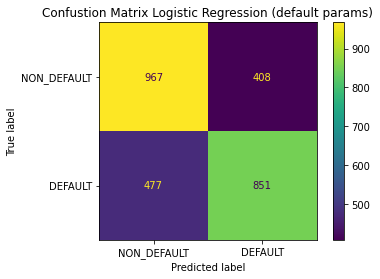

In [ ]:
# confusion matrix
if enable_logistic_regression:
  cm_display = metrics.ConfusionMatrixDisplay(cnf_matrix_test, display_labels=['NON_DEFAULT', 'DEFAULT'])
  cm_display.plot()
  cm_display.ax_.set_title('Confustion Matrix Logistic Regression (default params)')

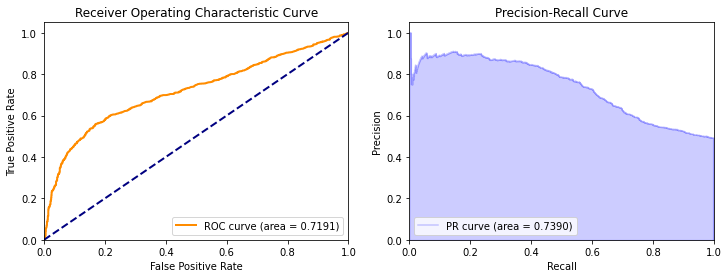

In [ ]:
# ROC and Precision-Recall Curve
if enable_logistic_regression:
  bcm = BinaryClassificationMetrics(lr_test_preds, scoreCol=lr_pipe.getStages()[-1].getProbabilityCol(), 
                                  labelCol=lr_pipe.getStages()[-1].getLabelCol() )
  
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  bcm.plot_roc_curve(ax=axs[0])
  bcm.plot_pr_curve(ax=axs[1])
  plt.show()

In [ ]:
# Feature Importance - Finding coefficients and intercept
if enable_logistic_regression:
  lr_coeffs = get_logistic_coefficients(lr_model.stages[0], lr_model.stages[-1], lr_test_preds)
  lr_coeffs

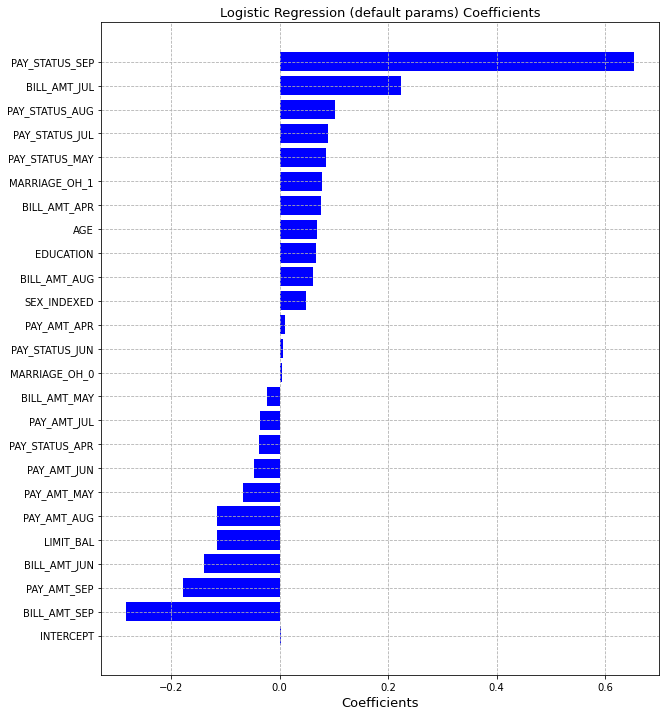

In [ ]:
# bar graph of model coefficients
if enable_logistic_regression:
  plt.figure(figsize=(10,12))
  plt.barh(y=lr_coeffs.index, width=lr_coeffs['Coefficient'], color='blue' )
  plt.grid(linestyle='--')
  plt.title('Logistic Regression (default params) Coefficients', fontdict={'fontsize':13})
  plt.xlabel('Coefficients',fontdict={'fontsize':13})
  plt.show()

### 5c. Logistic Regression Model (with CV & Regularization)

In [ ]:
# Model Building: Hyperparameter Tuning using Grid Search
if grid_search:
  if enable_logistic_regression:
    input_features_cv = fe_credit_df.columns
    input_features_cv.remove('DEFAULT_NEXT_MONTH') # label column

    # model buiding
    lr_cv_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=input_features_cv, outputCol='lr_cv_features'),
                               feature.StandardScaler(withMean=True, withStd=True, inputCol='lr_cv_features', outputCol='std_cv_features'),
                               classification.LogisticRegression(featuresCol='std_cv_features', labelCol='DEFAULT_NEXT_MONTH')])

    # hyper parameters for grid search
    lr_grid = ParamGridBuilder().addGrid(lr_cv_pipe.getStages()[-1].regParam, [0., 0.01, 0.15, 0.02, 0.25, 0.03, 0.35, 0.04, 0.05]).\
          addGrid(lr_cv_pipe.getStages()[-1].elasticNetParam, [0., 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]).build()
    
    lr_cv_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='DEFAULT_NEXT_MONTH', metricName='areaUnderROC')

    # 3 fold cross validation
    lr_cv = CrossValidator(estimator=lr_cv_pipe, estimatorParamMaps=lr_grid, evaluator=lr_cv_evaluator, numFolds=3)
    lr_cv_model_tuned = lr_cv.fit(train)

    print(f'Cross Validation AUCs: {lr_cv_model_tuned.avgMetrics}')
    print(f'Best Model AUC: {np.max(lr_cv_model_tuned.avgMetrics)}')

    print(f'Optimal RegParam (alpha): {lr_cv_model_tuned.bestModel.stages[-1].getRegParam()}')
    print(f'Optimal ElasticNetParam (lambda): {lr_cv_model_tuned.bestModel.stages[-1].getElasticNetParam()}')

In [ ]:
# Evaluation
if enable_logistic_regression:
  
  # Hyperparameters
  ALPHA = 0.25
  LAMBDA = 0.2

  input_features_tuned = fe_credit_df.columns
  input_features_tuned.remove('DEFAULT_NEXT_MONTH') # label column

  # model buiding
  lr_tuned_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=input_features_tuned, outputCol='lr_tuned_features'),
                                   feature.StandardScaler(withMean=True, withStd=True, inputCol='lr_tuned_features', outputCol='std_tuned_features'),
                                   classification.LogisticRegression(featuresCol='std_tuned_features', labelCol='DEFAULT_NEXT_MONTH',
                                                                     regParam=ALPHA, 
                                                                     elasticNetParam=LAMBDA)])
  
  lr_model_tuned = lr_tuned_pipe.fit(train)
  lr_tuned_preds = lr_model_tuned.transform(test)

  scores_tuned_train_lr, cnf_matrix_tuned_train_lr = binaryclf_evaluation(lr_model_tuned.transform(train), 'DEFAULT_NEXT_MONTH','prediction')
  scores_tuned_test_lr, cnf_matrix_tuned_test_lr = binaryclf_evaluation(lr_tuned_preds, 'DEFAULT_NEXT_MONTH','prediction')

  scores_tuned_lr = mergeDictionary(scores_tuned_train_lr, scores_tuned_test_lr)
  scores_tuned_lr_pd = pd.DataFrame.from_dict(scores_tuned_lr, orient='index', columns=['Train', 'Test'])
  scores_tuned_lr_pd = np.round(scores_tuned_lr_pd, 2)
  display(scores_tuned_lr_pd)

,Train,Test
AreaUnderROC,0.69,0.69
AreaUnderPR,0.71,0.72
Precision,0.78,0.78
Recall,0.53,0.53
F1 Score,0.63,0.63
Accuracy,0.69,0.69


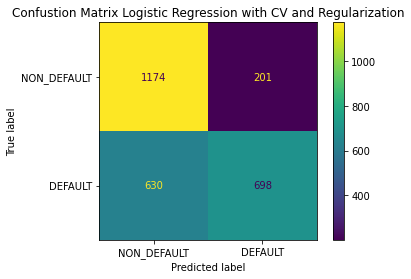

In [ ]:
# confusion matrix
if enable_logistic_regression:
  cm_display_tuned = metrics.ConfusionMatrixDisplay(cnf_matrix_tuned_test_lr, display_labels=['NON_DEFAULT', 'DEFAULT'])
  cm_display_tuned.plot()
  cm_display_tuned.ax_.set_title('Confustion Matrix Logistic Regression with CV and Regularization')

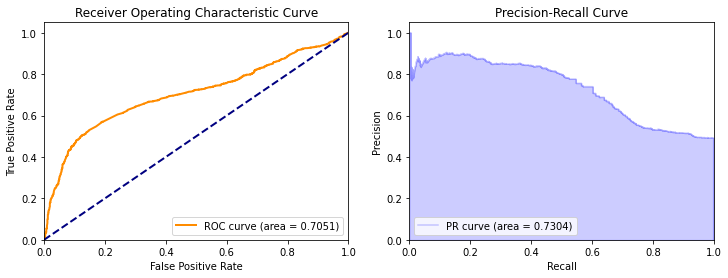

In [ ]:
# ROC and Precision-Recall Curve
if enable_logistic_regression:
  bcm_tuned = BinaryClassificationMetrics(lr_tuned_preds, scoreCol=lr_model_tuned.stages[-1].getProbabilityCol(),
                                          labelCol=lr_model_tuned.stages[-1].getLabelCol() )
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  bcm_tuned.plot_roc_curve(ax=axs[0])
  bcm_tuned.plot_pr_curve(ax=axs[1])
  plt.show()

In [ ]:
# Feature Importance - Finding coefficients and intercept
if enable_logistic_regression:
  lr_tuned_coeffs = get_logistic_coefficients(lr_model_tuned.stages[0], lr_model_tuned.stages[-1], lr_tuned_preds)
  lr_tuned_coeffs

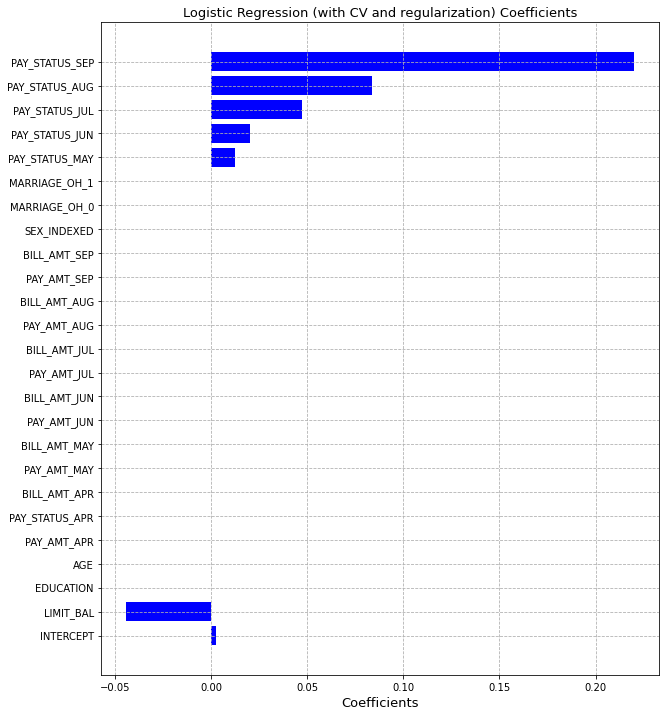

In [ ]:
# bar graph of model coefficients
if enable_logistic_regression:
  plt.figure(figsize=(10,12))
  plt.barh(y=lr_tuned_coeffs.index, width=lr_tuned_coeffs['Coefficient'], color='blue' )
  plt.grid(linestyle='--')
  plt.title('Logistic Regression (with CV and regularization) Coefficients', fontdict={'fontsize':13})
  plt.xlabel('Coefficients',fontdict={'fontsize':13})
  plt.show()

### 5d. Random Forest

In [ ]:
# Hyperparameter Tuning; Initial Trial with 480 models took about 3 hours to run
if grid_search:
  from pyspark.ml.tuning import ParamGridBuilder
  
  if enable_random_forest:
    input_features = fe_credit_df.columns
    input_features.remove('DEFAULT_NEXT_MONTH') # label column
    
    rf_gs = classification.RandomForestClassifier(featuresCol='final_features', labelCol='DEFAULT_NEXT_MONTH')

    grid = ParamGridBuilder().\
      addGrid(rf_gs.maxDepth, [4,5,6,7,8]).\
      addGrid(rf_gs.maxBins, [25,32,40]).\
      addGrid(rf_gs.numTrees, [15,20,25,30]).\
      addGrid(rf_gs.subsamplingRate, [0.1,0.25,0.5,1.0]).\
      addGrid(rf_gs.bootstrap, [True, False]).\
      build()
    
    rf_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=input_features, outputCol='rf_features'),
                             feature.StandardScaler(withMean=True, withStd=True, inputCol='rf_features', outputCol='final_features'),
                             rf_gs])
    
    all_models = []
    for j in range(len(grid)):
      model = rf_pipe.fit(train, grid[j])
      all_models.append(model)

    accuracies = [m.\
          transform(test).\
          select(f.avg(f.expr('float(DEFAULT_NEXT_MONTH = prediction)')).alias('accuracy')).\
          first().\
          accuracy for m in all_models]

    acc = 0
    index = 0
    for a in range(len(accuracies)):
        if accuracies[a] > acc:
            acc = accuracies[a]
            index = a

    print("Model Number " + str(index) + " has the largest accuracy:" + str(acc))
    print("\nGrid Parameters:", grid[index])
    pass

In [ ]:
if enable_random_forest:
  input_features = fe_credit_df.columns
  input_features.remove('DEFAULT_NEXT_MONTH') # label column

  rf_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=input_features, outputCol='rf_features'),
                             feature.StandardScaler(withMean=True, withStd=True, inputCol='rf_features', outputCol='final_features'),
                             classification.RandomForestClassifier(featuresCol='final_features', labelCol='DEFAULT_NEXT_MONTH',
                                                                   maxDepth = 8,
                                                                   maxBins = 32,
                                                                   numTrees = 25,
                                                                   subsamplingRate = 0.5,
                                                                   bootstrap = False)])

  rf_model = rf_pipe.fit(train)
  rf_test_preds = rf_model.transform(test)

In [ ]:
# Evaluation
if enable_random_forest:
  rf_scores_train, rf_matrix_train = binaryclf_evaluation(rf_model.transform(train), 'DEFAULT_NEXT_MONTH', 'prediction')
  rf_scores_test, rf_matrix_test = binaryclf_evaluation(rf_test_preds, 'DEFAULT_NEXT_MONTH','prediction')

  rf_scores = mergeDictionary(rf_scores_train,rf_scores_test)
  rf_scores_pd = pd.DataFrame.from_dict(rf_scores, orient='index', columns=['Train', 'Test'])
  rf_scores_pd = np.round(rf_scores_pd, 2)
  display(rf_scores_pd)

,Train,Test
AreaUnderROC,0.72,0.75
AreaUnderPR,0.71,0.75
Precision,0.77,0.80
Recall,0.61,0.65
F1 Score,0.68,0.72
Accuracy,0.72,0.75


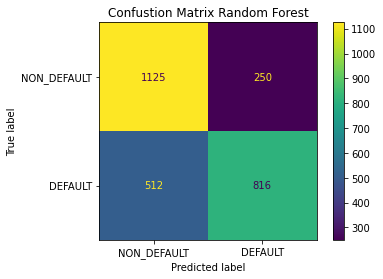

In [ ]:
# confusion matrix
if enable_random_forest:
  rf_cm_display = metrics.ConfusionMatrixDisplay(rf_matrix_test, display_labels=['NON_DEFAULT', 'DEFAULT'])
  rf_cm_display.plot()
  rf_cm_display.ax_.set_title('Confustion Matrix Random Forest')

In [ ]:
# data sampling for error trend
#rf_test_preds.filter(rf_test_preds.DEFAULT_NEXT_MONTH == 1).filter(rf_test_preds.prediction == 0).sample(fraction = 5/rf_test_preds.count()).toPandas().iloc[0]

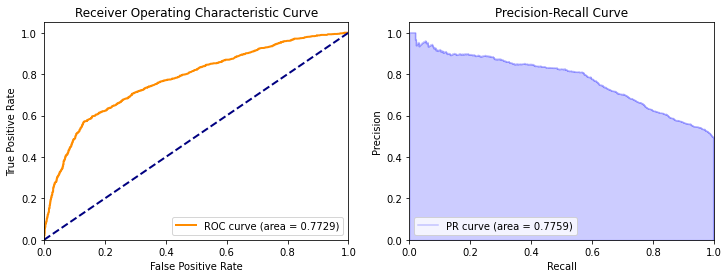

In [ ]:
# ROC and Precision-Recall Curve
if enable_random_forest:
  rf_bcm = BinaryClassificationMetrics(rf_test_preds, scoreCol=rf_pipe.getStages()[-1].getProbabilityCol(), 
                                  labelCol=rf_pipe.getStages()[-1].getLabelCol() )
  
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  rf_bcm.plot_roc_curve(ax=axs[0])
  rf_bcm.plot_pr_curve(ax=axs[1])
  plt.show()

In [ ]:
if enable_random_forest:
  display(pd.DataFrame(list(zip(input_features, rf_model.stages[-1].featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending = False))

,column,weight
19,PAY_STATUS_SEP,0.308210
16,PAY_STATUS_AUG,0.150473
7,PAY_STATUS_MAY,0.063270
10,PAY_STATUS_JUN,0.052292
0,LIMIT_BAL,0.050765
13,PAY_STATUS_JUL,0.046773
15,PAY_AMT_AUG,0.039390
12,PAY_AMT_JUL,0.034890
20,BILL_AMT_SEP,0.029207
18,PAY_AMT_SEP,0.027015


In [ ]:
if enable_random_forest:
  print(rf_model.stages[-1].trees[0].toDebugString)

DecisionTreeClassificationModel: uid=dtc_0eaeb97993b7, depth=8, numNodes=211, numClasses=2, numFeatures=24
  If (feature 16 <= 1.0571590815762664)
   If (feature 10 <= 0.405610120844469)
    If (feature 9 <= -0.18082357895674145)
     If (feature 19 <= 1.0131808860627343)
      If (feature 20 <= -0.6759061781383091)
       If (feature 11 <= -0.6547202881976333)
        If (feature 6 <= -0.15783998255563075)
         Predict: 1.0
        Else (feature 6 > -0.15783998255563075)
         Predict: 0.0
       Else (feature 11 > -0.6547202881976333)
        If (feature 12 <= -0.26410368349586355)
         If (feature 8 <= -0.612796913102726)
          Predict: 1.0
         Else (feature 8 > -0.612796913102726)
          Predict: 0.0
        Else (feature 12 > -0.26410368349586355)
         If (feature 0 <= -0.14924435212514173)
          Predict: 1.0
         Else (feature 0 > -0.14924435212514173)
          Predict: 0.0
      Else (feature 20 > -0.6759061781383091)
       If (feature 15 <= 

### 5e. Multilayer Perceptron Deep Learning Model

In [ ]:
mlp_train, mlp_test = undersampled_df.randomSplit(weights=[0.8, 0.2], seed=11292022)

print(f'dimensions of train: {(mlp_train.count(), len(mlp_train.columns))}') 
print(f'dimensions of test: {(mlp_test.count(), len(mlp_test.columns))}') 

dimensions of train: (10649, 24)
dimensions of test: (2703, 24)


In [ ]:
#hyperparameter tuning; 12 hidden layers with 28 total models and 2000 max iterations took 50 min to run
if grid_search:
  from pyspark.ml.tuning import ParamGridBuilder
  
  if enable_perceptron:
    input_features = undersampled_df.columns
    input_features.remove('DEFAULT_NEXT_MONTH') # label column

    mlp_gs = classification.MultilayerPerceptronClassifier(featuresCol='final_features', labelCol='DEFAULT_NEXT_MONTH').\
      setMaxIter(2000).\
      setLayers([len(input_features), 12, 2])

    grid = ParamGridBuilder().\
      addGrid(mlp_gs.blockSize, [64,128,256,512]).\
      addGrid(mlp_gs.stepSize, [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]).\
      build()
    
    mlp_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=input_features, outputCol='final_features'), mlp_gs])
    
    all_models = []
    for j in range(len(grid)):
      model = mlp_pipe.fit(mlp_train, grid[j])
      all_models.append(model)

    accuracies = [m.\
          transform(mlp_test).\
          select(f.avg(f.expr('float(DEFAULT_NEXT_MONTH = prediction)')).alias('accuracy')).\
          first().\
          accuracy for m in all_models]

    acc = 0
    index = 0
    for a in range(len(accuracies)):
        if accuracies[a] > acc:
            acc = accuracies[a]
            index = a

    print("Model Number " + str(index) + " has the largest accuracy:" + str(acc))
    print("\nGrid Parameters:", grid[index])
    pass

In [ ]:
if enable_perceptron:
  input_features = undersampled_df.columns
  input_features.remove('DEFAULT_NEXT_MONTH') # label column

  mlp_pipe = Pipeline(stages=[feature.VectorAssembler(inputCols=input_features, outputCol='final_features'),
                             classification.MultilayerPerceptronClassifier(featuresCol='final_features', labelCol='DEFAULT_NEXT_MONTH',
                                                                  blockSize = 64, stepSize = 0.005).\
                                                                  setMaxIter(200).setLayers([len(input_features), 23, 46, 23, 2])]) #initial at 25000 max iterations and 500 hidden layers

  mlp_model = mlp_pipe.fit(mlp_train)
  mlp_test_preds = mlp_model.transform(mlp_test)

In [ ]:
# Evaluation
if enable_perceptron:
  mlp_scores_train, mlp_matrix_train = binaryclf_evaluation(mlp_model.transform(mlp_train), 'DEFAULT_NEXT_MONTH', 'prediction')
  mlp_scores_test, mlp_matrix_test = binaryclf_evaluation(mlp_test_preds, 'DEFAULT_NEXT_MONTH','prediction')

  mlp_scores = mergeDictionary(mlp_scores_train,mlp_scores_test)
  mlp_scores_pd = pd.DataFrame.from_dict(mlp_scores, orient='index', columns=['Train', 'Test'])
  mlp_scores_pd = np.round(mlp_scores_pd, 2)
  display(mlp_scores_pd) #one hidden layer: 0.56

,Train,Test
AreaUnderROC,0.56,0.57
AreaUnderPR,0.54,0.56
Precision,0.56,0.57
Recall,0.54,0.54
F1 Score,0.55,0.55
Accuracy,0.57,0.57


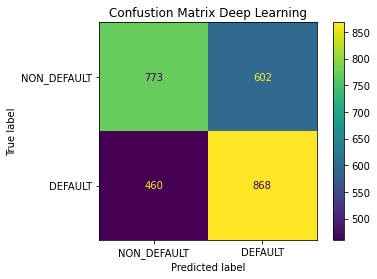

In [ ]:
# confusion matrix
if enable_perceptron:
  mlp_cm_display = metrics.ConfusionMatrixDisplay(mlp_matrix_test, display_labels=['NON_DEFAULT', 'DEFAULT'])
  mlp_cm_display.plot()
  mlp_cm_display.ax_.set_title('Confustion Matrix Deep Learning')

In [ ]:
# data sampling for error analysis
mlp_test_preds.filter(mlp_test_preds.DEFAULT_NEXT_MONTH == 1).filter(mlp_test_preds.prediction == 0).sample(fraction = 5/mlp_test_preds.count()).toPandas().iloc[0]

LIMIT_BAL                                                      300000.0
SEX                                                                   2
EDUCATION                                                             2
MARRIAGE                                                              1
AGE                                                                  34
PAY_AMT_APR                                                      2282.0
PAY_STATUS_APR                                                       -1
BILL_AMT_APR                                                     2920.0
PAY_AMT_MAY                                                      2920.0
PAY_STATUS_MAY                                                        0
BILL_AMT_MAY                                                     1701.0
PAY_AMT_JUN                                                         0.0
PAY_STATUS_JUN                                                        0
BILL_AMT_JUN                                                    

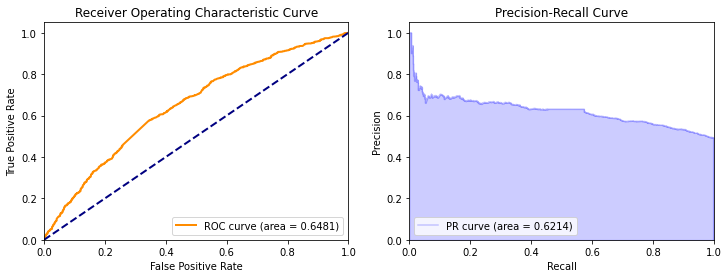

In [ ]:
# ROC and Precision-Recall Curve
if enable_perceptron:
  mlp_bcm = BinaryClassificationMetrics(mlp_test_preds, scoreCol=mlp_pipe.getStages()[-1].getProbabilityCol(), 
                                  labelCol=mlp_pipe.getStages()[-1].getLabelCol())
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  mlp_bcm.plot_roc_curve(ax=axs[0])
  mlp_bcm.plot_pr_curve(ax=axs[1])
  plt.show()

# 6. Model Comparison

In [ ]:
models_performance = [{'Model':'LogisticRegression', 'Accuracy':lr_scores_test['Accuracy'], 
                       'F1 Score':lr_scores_test['F1 Score'], 'Precision':lr_scores_test['Precision'], 
                       'Recall':lr_scores_test['Recall'], 'AUC_ROC':lr_scores_test['AreaUnderROC'], 'AUC_PR':lr_scores_test['AreaUnderPR']},
                      
                      {'Model':'LogisticRegression with Tuning', 'Accuracy':scores_tuned_test_lr['Accuracy'], 
                       'F1 Score':scores_tuned_test_lr['F1 Score'], 'Precision':scores_tuned_test_lr['Precision'], 
                       'Recall':scores_tuned_test_lr['Recall'], 'AUC_ROC':scores_tuned_test_lr['AreaUnderROC'], 
                       'AUC_PR':scores_tuned_test_lr['AreaUnderPR']},
                      
                      {'Model':'Random Forest', 'Accuracy':rf_scores_test['Accuracy'], 
                       'F1 Score':rf_scores_test['F1 Score'], 'Precision':rf_scores_test['Precision'], 
                       'Recall':rf_scores_test['Recall'], 'AUC_ROC':rf_scores_test['AreaUnderROC'], 'AUC_PR':rf_scores_test['AreaUnderPR']},
                      
                      {'Model':'Deep Learning', 'Accuracy':mlp_scores_test['Accuracy'], 
                       'F1 Score':mlp_scores_test['F1 Score'], 'Precision':mlp_scores_test['Precision'], 
                       'Recall':mlp_scores_test['Recall'], 'AUC_ROC':mlp_scores_test['AreaUnderROC'], 'AUC_PR':mlp_scores_test['AreaUnderPR']}]

model_comparison = pd.DataFrame(data=models_performance, columns= ['Model', 'Accuracy', 'F1 Score','Precision', 'Recall', 'AUC_ROC', 'AUC_PR'])
model_comparison = np.round(model_comparison,2)
model_comparison

,Model,Accuracy,F1 Score,Precision,Recall,AUC_ROC,AUC_PR
0,LogisticRegression,0.67,0.66,0.68,0.64,0.67,0.64
1,LogisticRegression with Tuning,0.69,0.63,0.78,0.53,0.69,0.71
2,Random Forest,0.72,0.68,0.77,0.61,0.72,0.71
3,Deep Learning,0.61,0.62,0.59,0.65,0.61,0.57


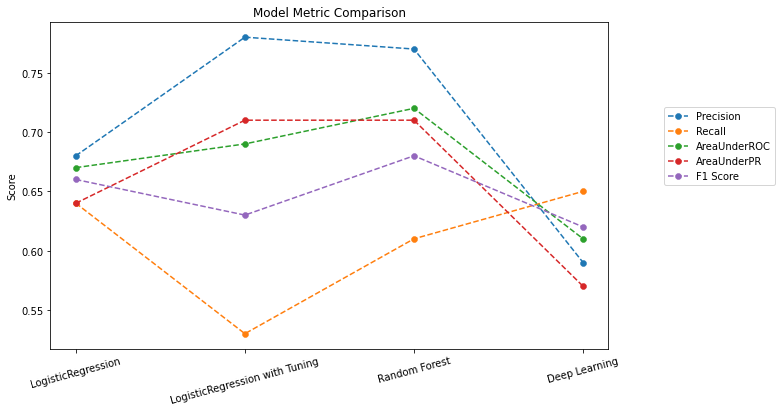

In [ ]:
# Line graph of all the model metrics
plt.figure(figsize=(10,6))

plt.plot(model_comparison.Model, model_comparison.Precision, label='Precision', linestyle="--", marker = 'o')
plt.plot(model_comparison.Model, model_comparison.Recall, label='Recall',linestyle="--", marker = 'o')
plt.plot(model_comparison.Model, model_comparison.AUC_ROC, label='AreaUnderROC',linestyle="--", marker = 'o')
plt.plot(model_comparison.Model, model_comparison.AUC_PR, label='AreaUnderPR',linestyle="--", marker = 'o')
plt.plot(model_comparison.Model, model_comparison['F1 Score'], label='F1 Score',linestyle="--", marker = 'o')

plt.legend(loc=(1.1,0.5))
plt.xticks(rotation = 15) # Rotates x-axis ticks by 45-degrees
plt.ylabel("Score")
plt.title("Model Metric Comparison")
plt.show()